# Customer Support RAG Agent

In this guide, you build an **agent** to perform **RAG** and answer questions related to a car manual PDF using [LlamaIndex](https://github.com/run-llama/llama_index), [Redis](https://redis.io), and [Amazon Bedrock](https://docs.aws.amazon.com/bedrock/).
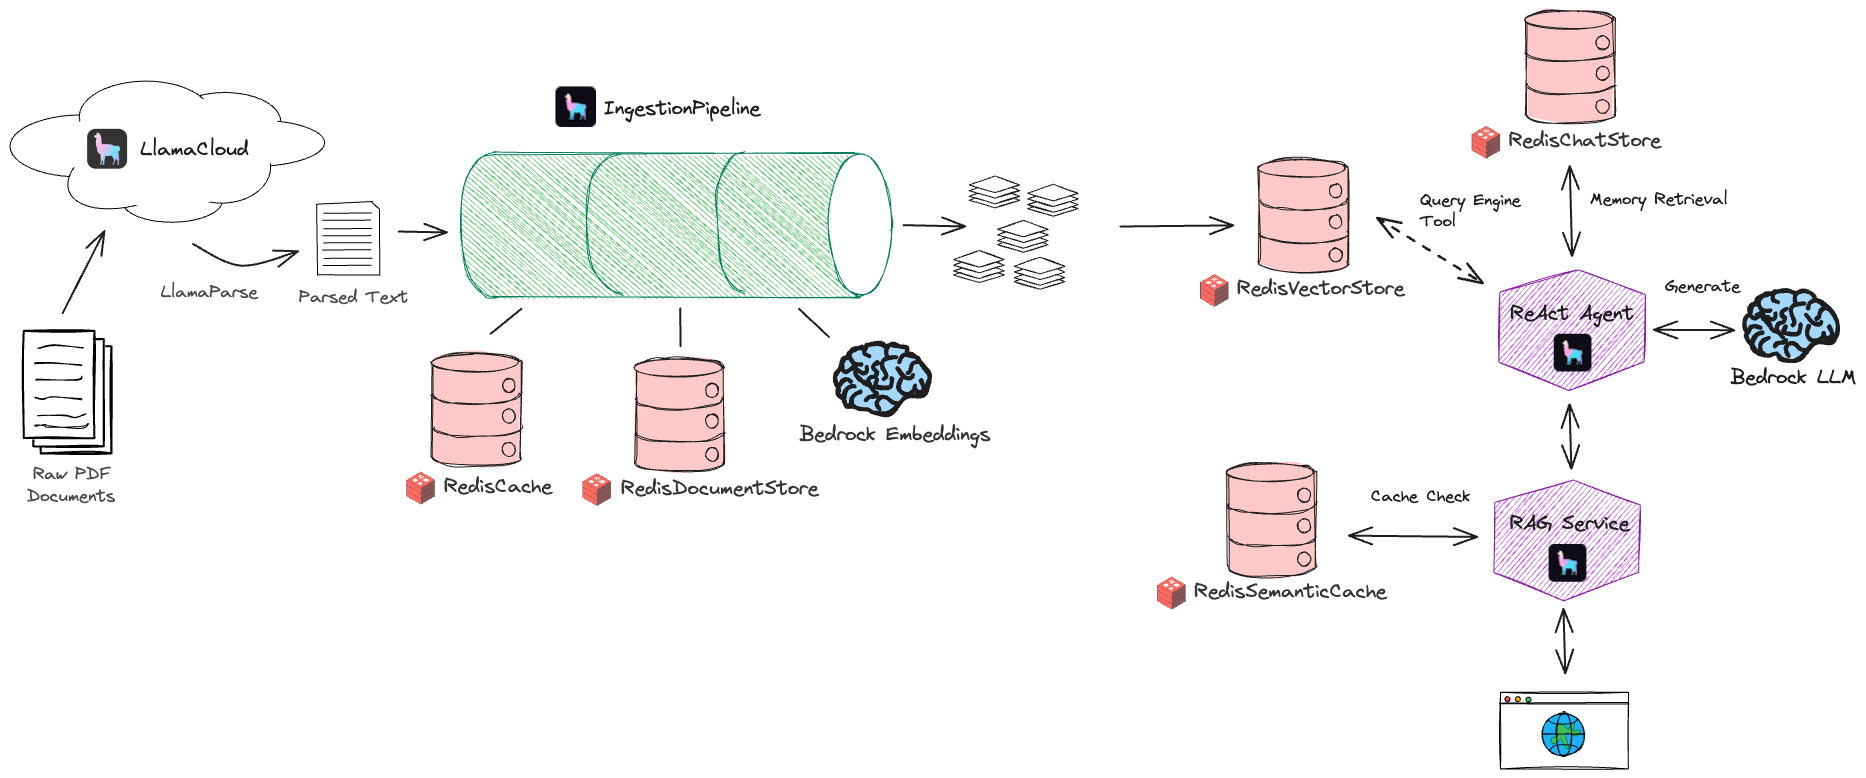

## Install Dependencies
First, you will need to install LlamaIndex 🦙 and a number of related integration dependencies.

In [ ]:
# @title
%pip install -U llama-index llama-parse llama-hub
%pip install llama-index-vector-stores-redis
%pip install llama-index-storage-docstore-redis
%pip install llama-index-storage-chat-store-redis
%pip install llama-index-llms-bedrock
%pip install llama-index-embeddings-bedrock
%pip install llama-index-embeddings-huggingface
%pip install sentence_transformers
%pip install testcontainers

In [ ]:
%load_ext autoreload
%autoreload 2

## Setup and Download Data

In this section, you will set up a Redis database, configure the environment, and ingest the PDF document.

### Start Redis
Start a new Redis instance. You need to have [Docker](https://www.docker.com) installed for this to work. This code uses a framework called [Testcontainers](https://testcontainers.com), which is an open source library for providing throwaway, lightweight instances of databases, message brokers, web browsers, or just about anything that can run in a Docker container.

💡 Note that you will need to explicitly stop the container created for Redis later on in this notebook. There is a section called **Stop Redis**, which will help you with this. Failing to do this will leave a container running blocking the port **6379**.

In [ ]:
from testcontainers.redis import RedisContainer
from testcontainers.core.container import DockerContainer

# Custom definition of a Redis server to allow direct access
class CustomRedisContainer(RedisContainer):
    def __init__(self, image="redis/redis-stack-server:7.4.0-v1", port=6379, **kwargs):
        super().__init__(image=image, **kwargs)
        self.port_to_expose = port
        self.with_exposed_ports(self.port_to_expose)

    def start(self):
        self.container = DockerContainer(self.image)
        self.container.with_exposed_ports(self.port_to_expose)
        self.container.with_command("redis-stack-server --protected-mode no --bind 0.0.0.0")
        self.container.ports = {self.port_to_expose: self.port_to_expose}
        self.container.start()
        return self

# Create and start the Redis container
redis_container = CustomRedisContainer()
redis_container.start()

### Environment Configuration
Here, you are going to set up the Redis connection details, as well as AWS and LlamaCloud API keys. To set this up, first open the [env.json](./env.json) file and adjust the values there. The code below will load the values from that file.


In [ ]:
import json

env_file = open("env.json")
env_data = json.load(env_file)

REDIS_HOST=env_data["redis"]["host"]
REDIS_PORT=env_data["redis"]["port"]

LLAMA_CLOUD_API_KEY=env_data["lhama"]["cloud_api_key"]

AWS_ACCESS_KEY_ID=env_data["aws"]["access_key_id"]
AWS_SECRET_ACCESS_KEY=env_data["aws"]["secret_access_key"]
AWS_REGION_NAME=env_data["aws"]["region_name"]

# llama-index need this code in Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

### Download, Parse and Ingest Document
You will download the PDF for this example. The code uses a simple bash command to pull the file from a related GitHub project.

In [ ]:
!mkdir -p 'data/'
!wget 'https://raw.githubusercontent.com/redis-developer/LLM-Document-Chat/main/docs/2022-chevrolet-colorado-ebrochure.pdf' -O 'data/2022-chevrolet-colorado-ebrochure.pdf'

Using LlamaParse on LlamaCloud, parsing the PDF is done with great precision and accuracy.

In [ ]:
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader

# Parse PDF document with LlamaParse
parser = LlamaParse(
    result_type="markdown",
    api_key=LLAMA_CLOUD_API_KEY
)

file_extractor = {".pdf": parser}
reader = SimpleDirectoryReader("./data", file_extractor=file_extractor)
documents = reader.load_data()


Next, you are going to build a custom index schema for the `RedisVectorStore` that uses the Amazon Bedrock embedding model along with some custom index specifications.

In [ ]:
from llama_index.embeddings.bedrock import BedrockEmbedding
from redisvl.schema import IndexSchema

embed_model = BedrockEmbedding(
    model_name="amazon.titan-embed-text-v1",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION_NAME,
)

custom_schema = IndexSchema.from_dict(
    {
        "index": {
            "name": "docs",
            "prefix": "chunk",
            "key_separator": ":"
          },
        # customize fields that are indexed
        "fields": [
            # required fields for llamaindex
            {"type": "tag", "name": "id"},
            {"type": "tag", "name": "doc_id"},
            {"type": "text", "name": "text"},
            # custom vector field for bedrock embeddings
            {
                "type": "vector",
                "name": "vector",
                "attrs": {
                    "dims": 1536,
                    "algorithm": "flat",
                    "distance_metric": "cosine",
                },
            },
        ],
    }
)

Now you can build an end to end ingestion pipeline as a sequence of transformations backed by a cache, document store, and a sink. **Notice that Redis is used at all stages of the ingest pipeline to process documents at scale, minimizing redundant compute (and thus long-running costs).**
![Architecture](images/architecture.png)

In [ ]:
from llama_index.core.ingestion import (
    DocstoreStrategy,
    IngestionPipeline,
    IngestionCache,
)
from llama_index.storage.kvstore.redis import RedisKVStore as RedisCache
from llama_index.storage.docstore.redis import RedisDocumentStore
from llama_index.core.node_parser import SentenceSplitter
from llama_index.vector_stores.redis import RedisVectorStore

doc_ingestion_pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(),
        embed_model,
    ],
    docstore=RedisDocumentStore.from_host_and_port(
        REDIS_HOST, REDIS_PORT, namespace="doc-store"
    ),
    vector_store=RedisVectorStore(
        schema=custom_schema,
        redis_url=f"redis://{REDIS_HOST}:{REDIS_PORT}",
    ),
    cache=IngestionCache(
        cache=RedisCache.from_host_and_port(REDIS_HOST, REDIS_PORT),
        collection="doc-cache",
    ),
    docstore_strategy=DocstoreStrategy.UPSERTS,
)

Now let's process the documents using the ingestion pipeline. Once this process is finished, you will notice the list of embedding vectors created. These vectors will also be stored at Redis.

In [ ]:
doc_ingestion_pipeline.run(documents=documents, show_progress=True)

## Build the ReAct Agent

In this section you will define a **ReAct** agent that will perform RAG over a PDF document using the Amazon Bedrock `ai21.j2-ultra-v1` large language model.

**ReAct** is an agent design pattern based on the ability to use tools. For each chat interaction, the agent enters a ReAct loop:

- Decide whether to use the query engine tool and come up with appropriate input
- Optionally use the query engine tool and observe its output
- Decide whether to iterate or give final response



### Agent Setup

Below you will define the LLM, embedding model, and a chat memory layer backed by Redis for conversation history and context.


In [ ]:
from llama_index.llms.bedrock import Bedrock
from llama_index.core import Settings

llm = Bedrock(
    model="ai21.j2-ultra-v1",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION_NAME,
)

Settings.llm = llm
Settings.embed_model = embed_model

# Build chat memory backed by Redis
from llama_index.storage.chat_store.redis import RedisChatStore
from llama_index.core.memory import ChatMemoryBuffer

chat_storage = RedisChatStore(redis_url=f"redis://{REDIS_HOST}:{REDIS_PORT}", ttl=300)
chat_memory = ChatMemoryBuffer.from_defaults(
    token_limit=3000,
    chat_store=chat_storage,
    chat_store_key="chat_history"
)

Next, you are going to set up and create the agent, which will allow user interactions to ask questions about the PDF document. Note that along with the agent, we also create a summary of the document. This is useful to verify if the integration between LhamaIndex, Redis, and the LLM works as expected.

In [ ]:
from llama_index.core.agent import ReActAgent
from llama_index.core import SummaryIndex, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.node_parser import SentenceSplitter

def build_doc_agent(doc):
    # ID will be base + parent
    file_name = doc.metadata["file_name"]
    file_path = f"./data/{file_name}"
    file_id = file_name.replace("-", "_").strip(".pdf")
    print(file_id)

    # Run ingestion
    doc_ingestion_pipeline.run(documents=[doc], show_progress=True)

    # Grab the nodes
    node_parser = SentenceSplitter()
    nodes = node_parser.get_nodes_from_documents([doc])

    # Build summary index and extract a summary
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(
        response_mode="tree_summarize"
    )
    summary = str(
        summary_query_engine.query(
            "Provide a summary of what this document is about."
        )
    )

    # Define vector index and query engine for the agent
    vector_index = VectorStoreIndex.from_vector_store(
        doc_ingestion_pipeline.vector_store
    )

    query_engine = vector_index.as_query_engine()

    # Define agent tools
    tools = [
        QueryEngineTool(
            query_engine=query_engine,
            metadata=ToolMetadata(
                name="car_manual",
                description=(
                    "Provides information about the specs and attributes of the Chevy Colorado 2022 car."
                    "Use a detailed plain text question as input to the tool."
                )
            ),
        )
    ]

    # Build ReAct agent
    agent = ReActAgent.from_tools(
        tools,
        llm=llm,
        verbose=True,
        memory=chat_memory,
        context="You are a specialized and helpful customer support agent designed to answer questions about the Chevy Colorado 2022 vehicle."
    )

    return agent, summary


Let's create the agent and the summary.

In [ ]:
agent, doc_summary = build_doc_agent(documents[0])

Let's output the summary to verify if everything is working as expected, before moving forward.

In [ ]:
doc_summary

## Using the Agent
Below you will use the agent to answer a few questions about the PDF document.
![Architecture](images/architecture.png)

In [ ]:
response = agent.chat("What is the seating capacity of the vehicle?")
print(str(response))

In [ ]:
response = agent.chat("What is the towing capacity?")

In [ ]:
response = agent.chat("Is there a trailer hitch on the back of the truck?")
print(str(response))

In [ ]:
response = agent.chat("Tell me about the pros and cons of this truck.")
print(str(response))

In [ ]:
agent.memory.chat_store.get_messages("chat_history")

### Incorporating Semantic Caching
You can use semantic caching to take advantage of frequently asked questions (live or pre-fetched) in order to improve response times. Different from a standard cache, a semantic cache also takes into consideration the meaning of the question. Users repeating an equivalent question—but not quite with the same words—will fetch the response from the cache instead of going to the LLM one more time.

In [ ]:
from redisvl.extensions.llmcache import SemanticCache
from redisvl.utils.vectorize import HFTextVectorizer

cache = SemanticCache(
    name="chevy_cache",
    prefix="cache",
    distance_threshold=0.2,
    ttl=60,
    vectorizer=HFTextVectorizer(model="BAAI/bge-small-en-v1.5")
)

def invoke_agent(prompt: str) -> str:
    if cached_result := cache.check(prompt=prompt):
        response = cached_result[0]['response']
        return response
    response = agent.chat(prompt)
    cache.store(prompt=prompt, response=response.response)
    return response.response

Now you can perform a simple test with our agent and semantic caching enabled.

In [ ]:
invoke_agent("How many doors does the truck have?")

In [ ]:
invoke_agent("How many passenger doors are on the truck?")

### Stop Redis
Since you reached the end of the notebook, please kill the container that is executing Redis.


In [ ]:
redis_container.container.stop()


### Extending Semantic Caching


There are a few options for working with semantic caching in a true production setting:
1.   Extract FAQs from your Knowledge Base (pdfs...). [Use an LLM to help!](https://github.com/redis-developer/redis-ai-resources/blob/main/python-recipes/semantic-cache/semantic_caching_gemini.ipynb) Or use human experts. Prefetch into the cache.
2. Carefully, extract FAQs from conversation history. Prefetch in batches into the cache each day or week.
3. Cache in realtime, which is tricky and requires some tuning. This should typically be done only at the USER level, not across the entire domain or application.